First it'd be best to setup the environment. I've copied the raw courses from: 
https://gist.github.com/pat-coady/26fafa10b4d14234bfde0bb58277786d

Because this would take a while and be pretty tedious to do myself.

But we'd still need to convert this to some other format. 

I think the best thing to do first would be to setup the environment, then from there work on the reinforcement learning part of it.

Now that the environment is setup, we need to setup the target and behaviour policies.

The target will just be a greedy deterministic policy.

The behaviour policy will be epsilon greedy.

In [54]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Racetracks
# Left Race Track from Figure 5.5
big_course = ['WWWWWWWWWWWWWWWWWW',
              'WWWWooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWooooooooooooooo+',
              'Woooooooooooooooo+',
              'Woooooooooooooooo+',
              'WooooooooooWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWW------WWWWWWWW']

# Tiny course for debug

tiny_course = ['WWWWWW',
               'Woooo+',
               'Woooo+',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'W--WWW',]

class RaceTrack:
    def __init__(self, course: list[str], max_velocity: int):
        self.course = self._load_course(course)
        self.max_velocity = max_velocity
        self.car_location = self._start() # List of coordinates (y, x)
        self.velocity = (0, 0) # Initial velocty
        self.actions = [(y, x) for y in range(-1, 2) for x in range(-1, 2)]
        self.action_idxs = np.arange(9)

    def _load_course(self, string_course: list[str]) -> np.array:
        course = np.zeros((len(string_course), len(string_course[0])), dtype=np.int16)
        course_dict = {"W": -1, "o": 0, "-": 1, "+": 2}

        for i in range(len(course)):
            for j in range(len(course[i])):
                course[i, j] = course_dict[string_course[i][j]]

        return course
    
    def _start(self) -> tuple[int, int]:
        rows, cols = np.where(self.course == 1)
        coords = list(zip(rows, cols)) # Combine into tuples
        start = random.randint(0, len(coords)-1) # Random int that defines start

        return coords[start]
    
    def _restart(self): # If we hit the car boundary
        self.car_location = self._start()
        self.velocity = (0, 0)
    
    def _apply_velocity(self, action: tuple[int, int]):
        y_vel = min(max(self.velocity[0] + action[0], 0), self.max_velocity) # Bound to between 0-5
        x_vel = min(max(self.velocity[1] + action[1], 0), self.max_velocity)
        self.velocity = (y_vel, x_vel)
    
    def _move(self, action) -> tuple:
        self._apply_velocity(action)

        y_vel, x_vel = self.velocity
        y, x = self.car_location

        width = len(self.course[0])
        all_positions = [(y, x)]
        max_vel = max(x_vel, y_vel)
        y_vel_count, x_vel_count = y_vel, x_vel
        y_temp, x_temp = y, x
        is_terminal = False
        is_out = False

        for _ in range(max_vel):
            if y_vel_count > 0 and x_vel_count > 0:
                y_temp -= 1
                x_temp += 1
                if y_temp < 0 or x_temp >= width:
                    all_positions.append("out")
                    is_out = True
                else:
                    all_positions.append((y_temp, x_temp))
                y_vel_count -= 1
                x_vel_count -= 1
            elif y_vel_count > 0:
                y_temp -= 1
                if y_temp < 0:
                    all_positions.append("out")
                    is_out = True
                else:
                    all_positions.append((y_temp, x_temp))
                y_vel_count -= 1
            else:
                x_temp += 1
                if x_temp >= width:
                    all_positions.append("out")
                    is_out = True
                else:
                    all_positions.append((y_temp, x_temp))
                x_vel_count -= 1

        all_position_values = []

        for i in all_positions:
            if i != "out":
                all_position_values.append(self.get_course()[*i])


        if 2 in all_position_values and -1 not in all_position_values:
            is_terminal = True
            self._restart()
        if -1 in all_position_values or is_out:
            self._restart()
        else:
            self.car_location = all_positions[-1]
        
        s_next = (*self.car_location, *self.velocity)
        if is_terminal:
            r = 0
        else:
            r = -1

        return (r, s_next, is_terminal)

    def get_height(self) -> int:
        return len(self.course)

    def get_width(self) -> int:
        return len(self.course[0])

    def get_course(self) -> np.array:
        return self.course

    def get_num_actions(self) -> int:
        return len(self.actions)

    def get_max_velocity(self) -> int:
        return self.max_velocity

    def get_state(self) -> tuple:
        state = (self.car_location[0], self.car_location[1], self.velocity[0], self.velocity[1])
        return state

    def pick_action(self, action_distribution: np.array) -> int: # Sample based on action distrbution
        action_idx = np.random.choice(self.action_idxs, 1, p=action_distribution)[0]
        return action_idx

    def step(self, action_idx) -> tuple: # Take action in environment
        action = self.actions[action_idx]
        return self._move(action) 

    def generate_episode(self, policy: np.array) -> list: # Generate episode under policy 
        self._restart()
        done = False
        trajectory = []

        while not done:
            y, x = self.car_location
            dy, dx = self.velocity
            state = (y, x, dy, dx)

            action_idx = self.pick_action(state) # Take action
            trajectory.append((*state, action_idx))

            action = self.actions[action_idx]

            _, _, is_terminal = self._move(action)
            if is_terminal:
                done = True

        return trajectory

def mark_possible(possible_actions: np.array, max_velocity: int) -> np.array:
    "Marks impossible actions as 0"
    actions = np.array([(dy, dx) for dy in range(-1, 2) for dx in range(-1, 2)])
    y_len, x_len, dy_len, dx_len, a_len = len(possible_actions), len(possible_actions[0]), 6, 6, len(actions)
    for y in range(y_len):
        for x in range(x_len):
            for dy in range(dy_len):
                for dx in range(dx_len):
                    for a in range(a_len):
                        dy_change, dx_change = actions[a]

                        new_dy = min(max(dy + dy_change, 0), max_velocity)
                        new_dx = min(max(dx + dx_change, 0), max_velocity)

                        if new_dy == 0 and new_dx == 0:
                            possible_actions[y, x, dy, dx, a] = 0

    return possible_actions

def init_equipropable_policy(policy: np.array, possible_actions: np.array) -> np.array:
    """Defines the equipropable policy where all possible actions have equal value
    Keyword being possible, as many actions aren't possible due to it causing velocity to be (0, 0)"""
    y_len, x_len, dy_len, dx_len = len(policy), len(policy[0]), policy.shape[2], policy.shape[2] # Height, Length, max_velocity+1, max_velocity+1
    for y in range(y_len):
        for x in range(x_len):
            for dy in range(dy_len):
                for dx in range(dx_len):
                    state = (y, x, dy, dx)
                    possible_actions_sum = np.sum(possible_actions[*state])
                    action_probabilty = 1/possible_actions_sum

                    possible_actions_mask = possible_actions[*state] == 1
                    policy[*state][possible_actions_mask] = action_probabilty 


    return policy

                    


In [104]:
from ensurepip import bootstrap
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

def mark_possible(possible_actions: np.array, max_velocity: int) -> np.array:
    "Marks impossible actions as 0"
    actions = np.array([(dy, dx) for dy in range(-1, 2) for dx in range(-1, 2)])
    y_len, x_len, dy_len, dx_len, a_len = len(possible_actions), len(possible_actions[0]), 6, 6, len(actions)
    for y in range(y_len):
        for x in range(x_len):
            for dy in range(dy_len):
                for dx in range(dx_len):
                    for a in range(a_len):
                        dy_change, dx_change = actions[a]

                        new_dy = min(max(dy + dy_change, 0), max_velocity)
                        new_dx = min(max(dx + dx_change, 0), max_velocity)

                        if new_dy == 0 and new_dx == 0:
                            possible_actions[y, x, dy, dx, a] = 0

    return possible_actions

class NStepLearning:
    def __init__(self, bootstrap_type: str, policy_type: str, env: RaceTrack, alpha: float, 
                gamma: float, epsilon: float, n: int, max_episodes: int
                ):
        self.boostrap_type = self.set_bootstrap(bootstrap_type) # Sarsa, Q-learning, Exepcted Sarsa, Importance Sampling, Control Variate, N-step Backuptree
        self.policy_type = self.set_policy_type(policy_type)
        self.env = env # Racetrack object
        self.alpha = alpha # Learning rate
        self.gamma = gamma # Discount rate
        self.epsilon = epsilon # Exploratory rate
        self.n = n # Number of steps before updating an state-action pair
        self.max_episodes = max_episodes # Max timesteps for learning
        self.num_actions = env.get_num_actions() # Get number of actions for epsilon-greedy
        self.height = env.get_height() # Height of gridowlrd
        self.width = env.get_width() # Width of gridworld
        self.max_velocity = env.get_max_velocity() # Max velocity (needed for matrix shapes)
        self.p_q_shape = (self.height, self.width, self.max_velocity+1, self.max_velocity+1, self.num_actions) # Shape of various arrays
        self.policy = np.zeros(self.p_q_shape, dtype=np.float64) # Target policy
        self.q_values = np.zeros(self.p_q_shape, dtype=np.float64) # Target policy q_values

        self.b_policy = np.zeros(self.p_q_shape, dtype=np.float64) # Behaviour policy
        self.b_q_values = np.zeros(self.p_q_shape, dtype=np.float64) # Behaviour q policy - for things like epsilon-greedy

        self.possible_actions = mark_possible(np.zeros(self.p_q_shape)+1, self.max_velocity)

        init_equipropable_policy(self.policy, self.possible_actions)
        init_equipropable_policy(self.b_policy, self.possible_actions)

        # For evaluation
        self.ep_count_hist = []
        
    def set_bootstrap(self, bootstrap_type: str):
        default = self._sarsa_bootstrap
        if bootstrap_type == "sarsa":
            bootstrap_type = self._sarsa_bootstrap
        elif bootstrap_type == "q-learning":
            bootstrap_type = self._q_learning_bootstrap
        elif bootstrap_type == "exp-sarsa":
            bootstrap_type = self._exp_bootstrap
        elif bootstrap_type == "backup-tree":
            bootstrap_type = self._backup_tree_bootstrap
        else:
            print(f"Update type: {bootstrap_type} not found, defaulting to f{default}")
            bootstrap_type = self._sarsa_bootstrap
        return bootstrap_type
    
    def set_policy_type(self, policy_type: str):
        default = self._on_policy_return
        if policy_type == "on-policy":
            policy_type = self._on_policy_return
        elif policy_type == "imp-sam":
            policy_type = self._importance_sampling
        elif policy_type == "con-var":
            policy_type = self._control_variate
        else:
            print(f"Policy type: {policy_type} not found, defaulting to f{default}")
            policy_type = default
        return policy_type

    def _on_policy_return(self, rewards: list, discount_rates: np.array) -> float:
        reward_arr = np.array([rewards])
        G = np.dot(reward_arr, discount_rates[:len(rewards)]).item() # Get item because it's a 1x1 array and need float
        return G

    def _sarsa_bootstrap(self, p_return: float, next_state_action: tuple, q_values: np.array, policy: np.array=None) -> float:
        p_return += q_values[next_state_action]
        return p_return

    def _q_learning_bootstrap(self, p_return: float, next_state_action: tuple, q_values: np.array, policy: np.array=None) -> float:
        p_return += np.max(q_values[*next_state_action[:-1]])
        return p_return
    
    def _exp_bootstrap(self, p_return: float, next_state_action: tuple, q_values: np.array, policy: np.array=None) -> float:
        p_return += np.dot(policy[*next_state_action[:-1]], q_values[*next_state_action[:-1]]).item()
        return p_return
    
    def visualise_policy(self, max_steps: int=1000):
        positions = []
        policy = self.policy
        env = self.env
        is_terminal = False
        step = 0

        env._restart()
        while not is_terminal:
            state = env.get_state()
            position = state[:2]
            positions.append(position)
            a = env.pick_action(policy[*state])
            _, _, is_terminal = env.step(a)
            step += 1


        gridworld = env.get_course().copy()    
        
        for i, j in positions:
            gridworld[i, j] = 3

        print(gridworld)
        print(step)


    def _update_policy(self, policy:np.array, q_values: np.array, epsilon: float, num_actions: int):
        best_a = np.argmax(q_values)

        policy[:] = 0
        policy[best_a] = 1-epsilon
        policy[:] += epsilon/num_actions
            
    def learn_greedy_behaviour(self, bootstrap_type: str, visualise: bool=False):
        ep_count = 0
        steps_per_episode = []
        n = self.n
        gamma = self.gamma
        discount_rates = np.array([gamma**x for x in range(n)])
        q_values = self.b_q_values
        policy = self.b_policy
        alpha = self.alpha
        env = self.env
        max_episodes = self.max_episodes
        bootstrap_type = self.set_bootstrap(bootstrap_type)
        num_actions = self.num_actions
        epsilon = self.epsilon

        if visualise:
            fig, ax = plt.subplots(figsize=(8, 4))
            line, = ax.plot([], [], label="Steps to finish")
            ax.set_xlabel("Episode")
            ax.set_ylabel("Steps")
            ax.set_title("Training progress")
            ax.legend()

        while ep_count < max_episodes:
            s = env.get_state()
            t_terminal = np.inf
            t = 0 
            is_ep_done = False
            rewards = []
            state_actions = []

            while not is_ep_done:
                if t < t_terminal:
                    a = env.pick_action(policy[*s])
                    r, s_next, is_terminal = env.step(a)
                    rewards.append(r)
                    state_actions.append((*s, a))
                    if is_terminal:
                        t_terminal = t+1
                        ep_count += 1
                tau = t - n + 1

                if tau >= 0:
                    p_G = self._on_policy_return(rewards, discount_rates)
                    rewards.pop(0)
                    state_action = state_actions.pop(0)
                    if tau + n < t_terminal:
                        n_state_action = state_actions[-1]
                        G = self.boostrap_type(p_G, n_state_action, q_values, policy)

                    q_values[*state_action] += alpha * (G - q_values[*state_action])

                    self._update_policy(policy[*state_action[:-1]], q_values[*state_action[:-1]], epsilon, num_actions)

                if tau == t_terminal-1:
                    is_ep_done = True

                t += 1

            steps_per_episode.append(t)

            if visualise:
                line.set_ydata(steps_per_episode)
                line.set_xdata(np.arange(len(steps_per_episode)))
                ax.relim()
                ax.autoscale_view()
                
                clear_output(wait=True)
                display(fig)


    def learn(self, visualise: bool=True):
        ep_count = 0
        ep_rewards = []
        steps_per_episode = []
        avg_rewards = []
        n = self.n
        gamma = self.gamma
        discount_rates = np.array([gamma**x for x in range(n)])
        q_values = self.q_values
        policy = self.policy
        alpha = self.alpha
        max_episodes = self.max_episodes
        env = self.env
        bootstrap_type = self.boostrap_type
        policy_type = self.policy_type
        num_actions = self.num_actions
        epsilon = self.epsilon

        if visualise:
            fig, ax = plt.subplots(figsize=(8, 4))
            steps_line, = ax.plot([], [], color="blue", label="Steps per episode")
            reward_line, = ax.plot([], [], color="red", label="Cumulative rewards")
            ax.set_xlabel("Episode")
            ax.set_ylabel("Value")
            ax.set_title("Training progress")
            ax.legend()

        while ep_count < max_episodes:
            s = env.get_state()
            t_terminal = np.inf
            t = 0 
            is_ep_done = False
            rewards = []
            state_actions = []
            ep_reward = 0

            while not is_ep_done:
                if t < t_terminal:
                    a = env.pick_action(policy[*s])
                    r, s_next, is_terminal = env.step(a)

                    rewards.append(r)
                    ep_reward += r
                    state_actions.append((*s, a))
                    if is_terminal:
                        t_terminal = t+1
                        ep_count += 1
                tau = t - n + 1

                if tau >= 0:
                    G = policy_type(rewards, discount_rates)
                    rewards.pop(0)
                    state_action = state_actions.pop(0)
                    if tau + n < t_terminal:
                        n_state_action = state_actions[-1]
                        G = bootstrap_type(G, n_state_action, q_values, policy)

                    q_values[*state_action] += alpha * (G - q_values[*state_action])

                    # Update policy for state
                    self._update_policy(policy[*state_action[:-1]], q_values[*state_action[:-1]], epsilon, num_actions)

                if tau == t_terminal-1:
                    is_ep_done = True

                t += 1
            
            ep_rewards.append(ep_reward)
            avg_rewards.append(sum(ep_rewards) / len(ep_rewards))
            
            steps_per_episode.append(t)

            if visualise:
                x = np.arange(len(steps_per_episode))
                steps_line.set_ydata(steps_per_episode)
                steps_line.set_xdata(x)
                reward_line.set_ydata(avg_rewards)
                reward_line.set_xdata(x)
                ax.relim()
                ax.autoscale_view()
                
                clear_output(wait=True)
                display(fig)


        

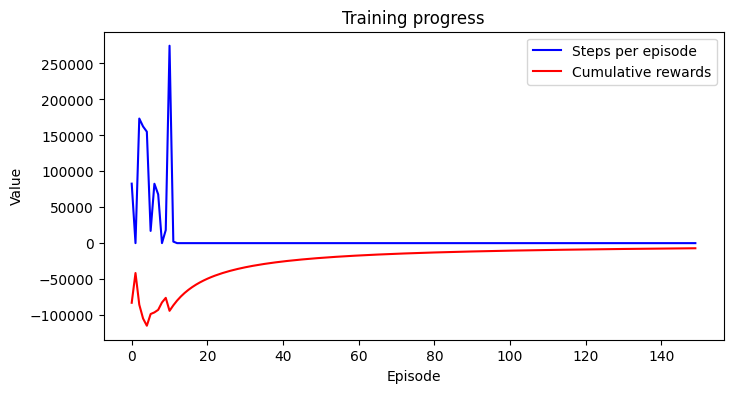

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0  0  0  3  3  3  0  0  3  0  0  0  0  2]
 [-1 -1 -1  0  0  0  3  3  0  0  3  3  0  0  0  0  0  2]
 [-1 -1 -1  0  0  0  3  3  0  3  3  3  0  0  0  0  0  2]
 [-1 -1  0  0  0  0  3  3  0  3  3  3  0  0  3  0  0  2]
 [-1  0  0  0  0  0  3  3  3  3  3  0  0  0  0  0  0  2]
 [-1  0  0  0  0  3  0  0  0  3  0  0  0  0  0  0  0  2]
 [-1  0  0  0  0  0  0  3  3  3  0 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  3  0  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  3  0  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  0  0  0  3  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  0  0  0  0  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  0  0  0  0  3  3  3  3

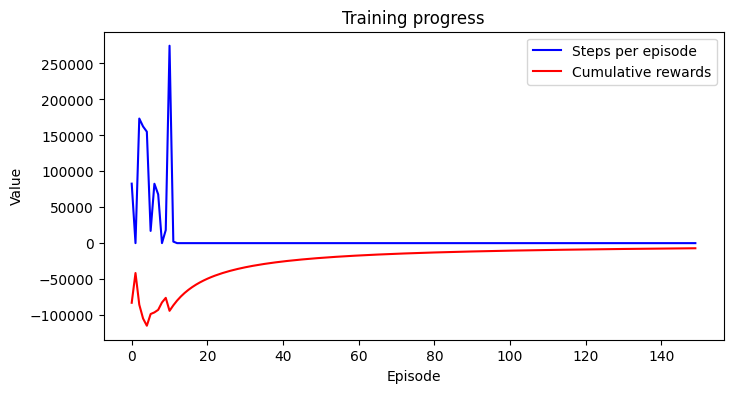

In [105]:
import random
import numpy as np
random.seed(1)
np.random.seed(1)

# Define environment constants
MAX_VELOCITY = 5
COURSE = big_course

# Define learning constants
GAMMA = 0.99 # Discount rate
EPSILON = 0.001 # Exploration factor for on-policy
THETA = 1e-3 # Breaking factor
ALPHA = 0.10
N = 200
MAX_EPISODES = 150

# Learner parameters
bootstrap_type = "q-learning"
return_type = "on-policy"
environment = RaceTrack(COURSE, MAX_VELOCITY)
visualise = True


learner = NStepLearning(bootstrap_type, return_type, environment, ALPHA, GAMMA, EPSILON, N, MAX_EPISODES)


learner.learn(visualise)
learner.visualise_policy(500)
#learner.learn_greedy_behaviour(bootstrap_type, visualise)

In [106]:
print(np.sum(learner.q_values))

-396111.76711331634


In [109]:
learner.visualise_policy(1000)

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0  0  3  0  3  3  3  3  0  3  3  3  3  2]
 [-1 -1 -1  0  0  0  0  3  3  3  3  3  0  0  0  0  3  2]
 [-1 -1 -1  0  0  0  3  0  3  3  3  0  0  3  0  0  0  2]
 [-1 -1  0  0  0  3  3  3  3  3  3  3  0  0  0  0  0  2]
 [-1  0  0  0  0  0  0  3  3  3  0  3  0  0  0  0  0  2]
 [-1  0  0  0  0  0  3  0  3  3  3  0  0  0  0  0  0  2]
 [-1  0  0  0  0  0  0  3  3  3  0 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  3  0  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  3  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  3  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  3  3  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  0  0  0  3  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  0  0  0  3  3  3  3  3 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  0  0  0  3  3  3  3  3

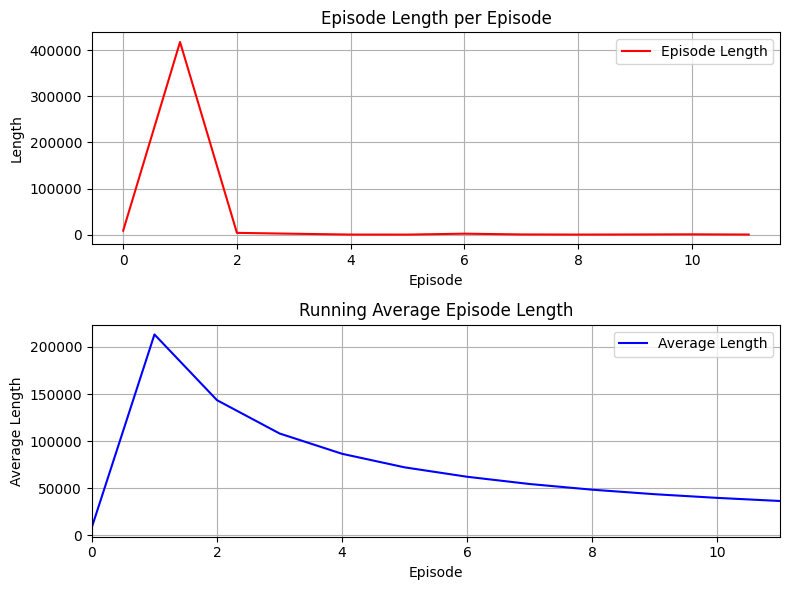

KeyboardInterrupt: 

In [ ]:
import numpy as np
random.seed(1)
np.random.seed(1)

course = big_course
actions = np.array([(dy, dx) for dy in range(-1, 2) for dx in range(-1, 2)])

# Define map constants
MAX_VELOCITY = 5

# Define learning constants
GAMMA = 1 # Discount rate
EPSILON = 0.05 # Exploration factor for on-policy
THETA = 1e-3 # Breaking factor

# Setup behaviour policy
# Actions here could be represented as an array of size (9) or (3, 3)
# If it were 9, then the actions are grouped to be (-1, -1), (-1, 0), ..., (1, 1) etc.
# If it were (3, 3), then there's 3 possible actions for each axis, but I think this would be more annoying to implement

behaviour_policy = np.zeros((len(course), len(course[0]), MAX_VELOCITY+1, MAX_VELOCITY+1, len(actions))) # Begin as equiprobable policy, will be stochastic
behaviour_q_values = np.zeros(behaviour_policy.shape)
behaviour_policy_counts = np.zeros(behaviour_policy.shape)

possible_actions = np.zeros((len(course), len(course[0]), MAX_VELOCITY+1, MAX_VELOCITY+1, len(actions))) + 1 # Initially all actions are possible
possible_actions = mark_possible(possible_actions) # Mark impossible actions (impossilbe as per the problem description)

behaviour_policy = init_equipropable_policy(behaviour_policy, possible_actions) # Initialise all possilbe actions with equal possibility

race_track = RaceTrack(course, MAX_VELOCITY)

def on_policy_monte_carlo_control(race_track: RaceTrack, policy: np.array, q_values: np.array, counts: np.array, 
                                  gamma: float, epsilon: float, possible_actions: np.array, theta, 
                                  max_iterations: int = 200_000) -> np.array:
    episode_length_history = []
    episode_average_history = []

    for _ in range(max_iterations):
        state_action_trajectory = race_track.generate_episode(policy)
        current_return = 0
        timestep = len(state_action_trajectory)
        old_policy = policy.copy()
        old_q = q_values.copy()

        for state_action in reversed(state_action_trajectory):
            current_return = gamma * current_return + -1 # Taking advantage of how the reward structure for the problem is
            # We don't need the explicit overall reward as it's just the negative of the length of the trajectory
            timestep -= 1
            
            """
            If we want to use first-visit, we'd add this line:
            if state_action not in state_action_trajectory[:timestep]:
            
            However this makes it MUCH slower, increasing it from O(n) to O(n^2) as we need to check the whole trajectory for each timestep.
            So every-visit is MUCH faster in practice as it's O(n)

            """
            counts[*state_action] += 1
            q_values[*state_action] += (current_return-q_values[*state_action])/counts[*state_action]
            
            # Get Argmax (vectorised)
            possible_mask = possible_actions[*state_action[:-1]] == 1 
            best_a_idx = np.argmax(np.where(possible_mask, q_values[*state_action[:-1]], -np.inf))
            
            possible_actions_sum = np.sum(possible_actions[*state_action[:-1]])
            random_probability = epsilon/possible_actions_sum

            # Assign probabilities (vectorised)
            policy[*state_action[:-1]][possible_mask] = random_probability
            policy[*state_action[:-1], best_a_idx] += (1-epsilon)

        if np.all(old_policy == policy) and np.allclose(q_values, old_q, atol=theta): # Breaking condition
            return policy

        episode_length_history.append(len(state_action_trajectory))
        episode_average_history.append(sum(episode_length_history)/len(episode_length_history))

        window = 500

        n = len(episode_average_history)
        start = max(0, n-window)

        x_full = np.arange(n)
        x_win = x_full[start:]

        y_win = np.array(episode_average_history[start:])

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        # --- Subplot 1: Episode Lengths ---
        ax1.plot(episode_length_history, color="red", label="Episode Length")
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Length")
        ax1.set_title("Episode Length per Episode")
        ax1.legend()
        ax1.grid(True)

        # --- Subplot 2: Average Lengths ---
        ax2.plot(x_win, y_win, color="blue", label="Average Length")
        ax2.set_xlabel("Episode")
        ax2.set_ylabel("Average Length")
        ax2.set_title("Running Average Episode Length")
        ax2.legend()
        ax2.grid(True)

        ax2.set_xlim(start, max(start + 1, n - 1))

        plt.tight_layout()
        plt.show()
        
plt.ion()
#behaviour_policy = on_policy_monte_carlo_control(race_track, behaviour_policy, behaviour_q_values, behaviour_policy_counts, GAMMA, EPSILON, possible_actions, THETA)



In [1]:
from tqdm import tqdm

# Off policy

target_q_values = np.zeros((len(course), len(course[0]), MAX_VELOCITY+1, MAX_VELOCITY+1, len(actions))) # len(x), len(y), 6 speeds up and down (0-6), 9 possible actions. If it were state values, we'd just need v = x, y, 5, 5
target_policy = np.zeros((len(course), len(course[0]), MAX_VELOCITY+1, MAX_VELOCITY+1), dtype=np.int32) + 4 # Need an array for each state, default value set to (0, 0), no need for 9 actions per state as it's deterministic, so just set it as the index
c_values = np.zeros(target_q_values.shape) # Need the same shape for our running importance sampling sum

race_track = RaceTrack(course)

def off_policy_monte_carlo(race_track: RaceTrack, target_policy: np.array, target_q_values: np.array, behaviour_policy: np.array,
                            possible_actions: np.array, gamma: float, max_iterations: int = 50_000) -> np.array:
    c_values = np.zeros(target_q_values.shape)

    for i in tqdm(range(max_iterations)):
        traj = race_track.generate_episode(behaviour_policy)
        G = 0 # Return
        W = 1 # Running importance sampling ratio

        for state_action in reversed(traj):
            G = gamma * G + -1
            c_values[*state_action] += W 
            target_q_values[*state_action] += (W/c_values[*state_action]) * (G-target_q_values[*state_action])
            
            possible_actions_mask = possible_actions[*state_action[:-1]] == 1
            best_a_idx = np.argmax(np.where(possible_actions_mask, target_q_values[*state_action[:-1]], -np.inf))
            target_policy[*state_action[:-1]] = best_a_idx

            if target_policy[*state_action[:-1]] != state_action[-1]:
                break 
            else:
                W =  W * (1/behaviour_policy[state_action])

    return target_policy


target_policy = off_policy_monte_carlo(race_track, target_policy, target_q_values, behaviour_policy, possible_actions, GAMMA)
print("Reward: ", len(race_track.generate_episode(target_policy)))



NameError: name 'np' is not defined

In [93]:

print(behaviour_policy[0, 0, 0, 0].shape)
print(target_policy[0, 0, 0, 0].shape)

print(target_policy[0, 0, 0, 0].shape == ())

(9,)
()
True
